# Garbage Bin Classification


For this project 4,068 images were collected. With the following distribution:

- **Blue bin** (recyclable): 2,398 images
- **Green bin** (compostable):      826 images
- **Black bin** (landfill):         844 images 


For this project, your team needs to develop/implement/code the garbage classification model. You are free to use any technique seen in class that you want (*e.g.*, CNNs, transfer learning, etc.). You will have access only to the development set.
The development set can be downloaded here:



The Jupyter Notebook should be divided into two parts: 1. Model development; 2. Model testing. The model development will be run by you, while the model testing will be run by the TAs when grading the project.


## 1. Model development;

In [40]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
from skimage import transform
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Activation,Input
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import glob
import matplotlib.pyplot as plt
from skimage import transform

## LOADING AND EXPLORING OUR DATA

In [41]:
fpath = "C:\\ENEL 645 ASSIGNMENT 4\\Garbage-classification-dataset (1)\\Development"   #File path to developmemt set
random_seed = 111

#Printing number and types of category
categories = os.listdir(fpath)
for directory in categories:
    if directory == ".DS_Store":
        categories.remove(directory) # remove .DS_Store from list
    else:
        pass
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))

List of categories =  ['Black', 'Blue', 'Green'] 

No. of categories =  3


In [42]:
class_names = ["Black", "Blue", "Green"]
images = np.asarray(glob.glob(fpath + "/*/*.png"))
labels = np.asarray([f.split("\\")[-2] for f in images])
print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(len(images))
print(images[:4])
print(labels[:5])

Images shape =  (3768,) 
Labels shape =  (3768,)
3768
['C:\\ENEL 645 ASSIGNMENT 4\\Garbage-classification-dataset (1)\\Development\\Black\\black_0.png'
 'C:\\ENEL 645 ASSIGNMENT 4\\Garbage-classification-dataset (1)\\Development\\Black\\black_1.png'
 'C:\\ENEL 645 ASSIGNMENT 4\\Garbage-classification-dataset (1)\\Development\\Black\\black_10.png'
 'C:\\ENEL 645 ASSIGNMENT 4\\Garbage-classification-dataset (1)\\Development\\Black\\black_100.png']
['Black' 'Black' 'Black' 'Black' 'Black']


In [43]:
# Representing class names as integers 
Y = np.zeros(len(labels))
for ii in range(len(class_names)):
    Y[labels == class_names[ii]] =  ii

In [44]:
# we will resize the images
img_height = 180
img_width = 180

X = np.zeros((len(images),img_height,img_width,3))
for (ii,img) in enumerate(images):
    X[ii] = transform.resize(plt.imread(img),(img_height,img_width,3))

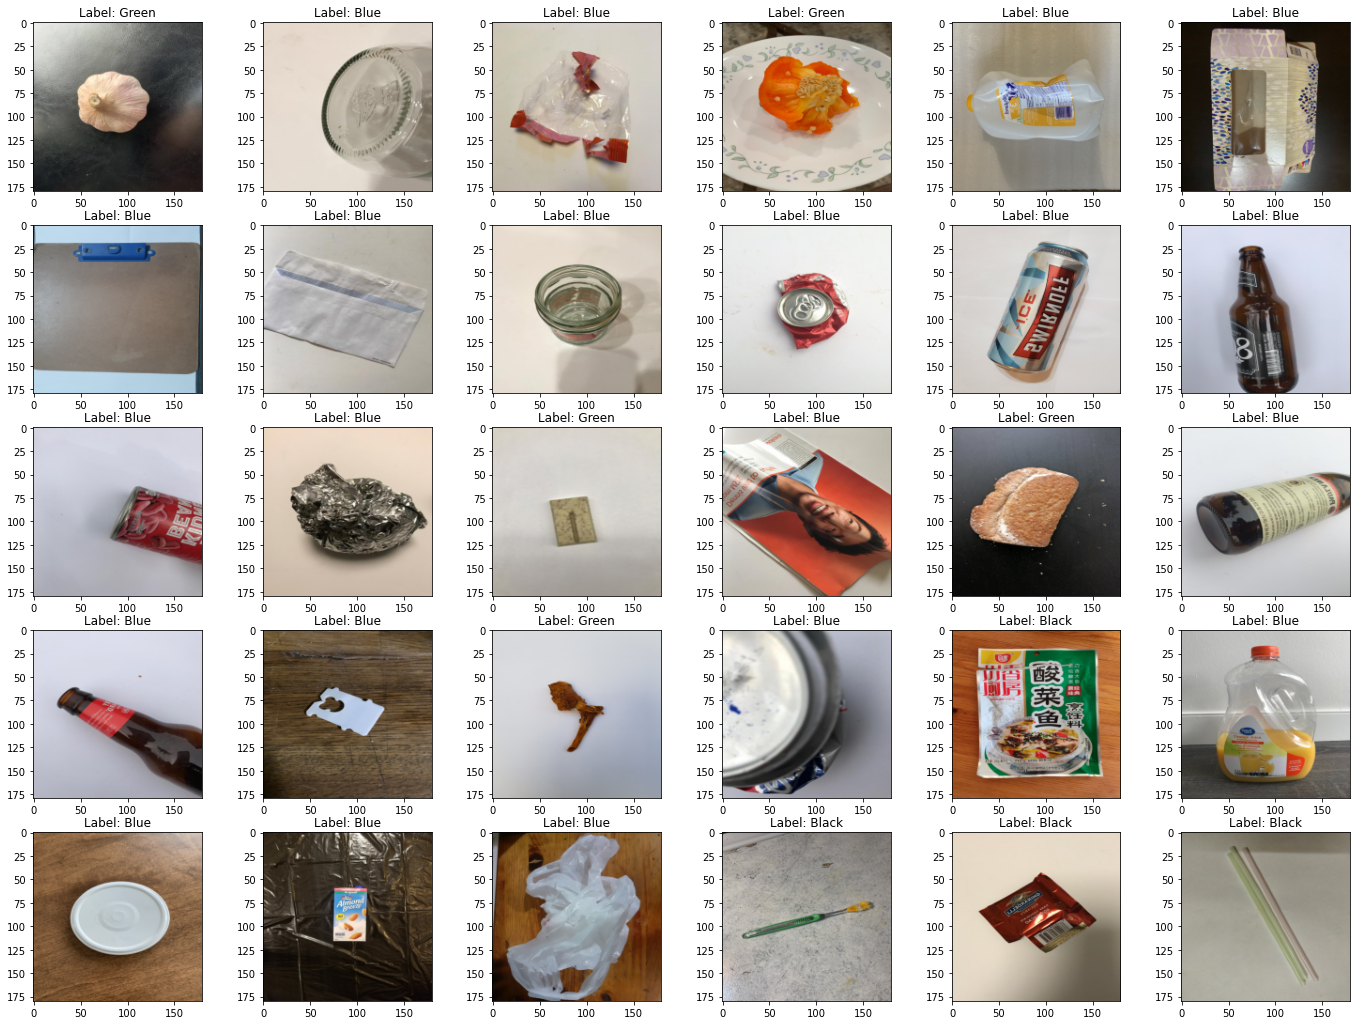

In [45]:
# Displaying some samples from the development set
sample_indexes = np.random.choice(np.arange(X.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X[jj], cmap = "gray")
    plt.title("Label: %s" %class_names[int(Y[jj])])
plt.show()

In [46]:
#The number of classes across samples look balanced
# Let's shuffle the samples and split them
indexes = np.arange(X.shape[0], dtype = int)
np.random.shuffle(indexes)
X = X[indexes]
Y = Y[indexes]

nsplit = int(0.90*X.shape[0]) # Train/validation split

# Train and validation split
X_train = X[:nsplit]
Y_train = Y[:nsplit]
X_val = X[nsplit:]
Y_val = Y[nsplit:]

print("\nTrain set")
print("Images: ",X_train.shape)
print("Labels shape: ",Y_train.shape)
print("\nValidation set")
print("Images: ",X_val.shape)
print("Labels shape: ",Y_val.shape)


Train set
Images:  (3391, 180, 180, 3)
Labels shape:  (3391,)

Validation set
Images:  (377, 180, 180, 3)
Labels shape:  (377,)


In [47]:
# The data seems to be already scaled between 0 and 1, so we do nothing
print(X_train.min(),X_train.max(),X_train.mean(),X_train.std())
print(X_val.min(),X_val.max(),X_val.mean(),X_val.std())

0.0 1.0 0.59793928555445 0.23212849989307674
0.0 1.0 0.5954561597389729 0.22906985695358625


## ONE-HOT ENCODING

In [48]:
Y_train_oh = tf.keras.utils.to_categorical(Y_train)
Y_val_oh = tf.keras.utils.to_categorical(Y_val)

print("Labels:")
print(Y_train[:5])
print()
print("One hot encoded labels:")
print(Y_train_oh[:5])

Labels:
[0. 1. 0. 1. 0.]

One hot encoded labels:
[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


## DATA AUGMENTATION

In [49]:
batch_size = 32
gen_params = {"featurewise_center":False,"samplewise_center":False,"featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,"zca_whitening":False,"rotation_range":20,"width_shift_range":0.1,"height_shift_range":0.1,\
              "shear_range":0.2, "zoom_range":0.1,"horizontal_flip":True,"fill_mode":'constant',\
               "cval": 0}
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params)

train_gen.fit(X_train,seed = 1)
val_gen.fit(X_val, seed = 1)

train_flow = train_gen.flow(X_train,Y_train_oh,batch_size = batch_size)
val_flow = val_gen.flow(X_val,Y_val_oh,batch_size = batch_size)

0.54389685 0.2878275
0.0 1.0


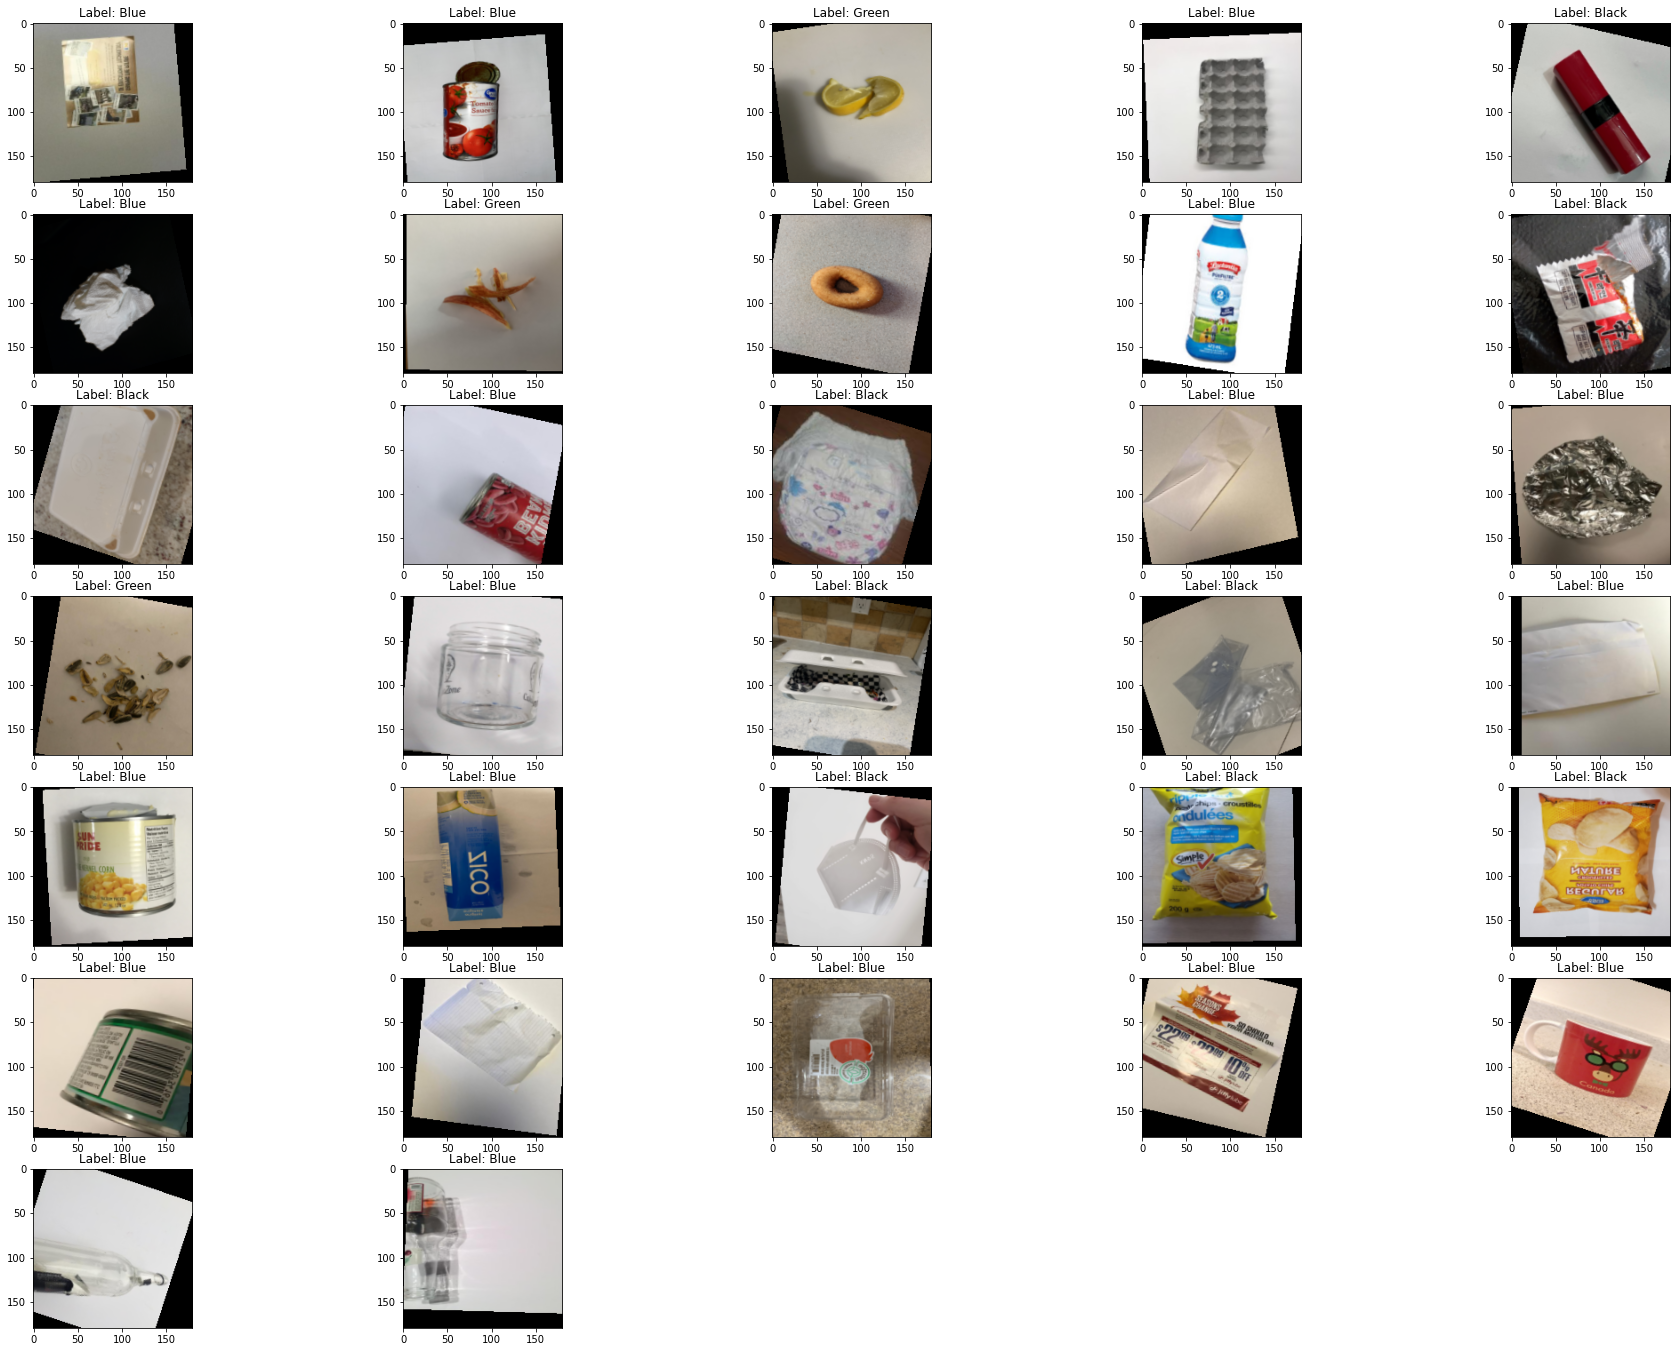

In [50]:
# Displaying some samples from the development set
plt.figure(figsize = (32,24))
Xbatch,Ybatch = train_flow.__getitem__(0)
print(Xbatch.mean(),Xbatch.std())
print(Xbatch.min(),Xbatch.max())
for ii in range(batch_size):
    plt.subplot(7,5,ii+1)
    plt.imshow((Xbatch[ii]- Xbatch[ii].min())/(Xbatch.max() - Xbatch[ii].min()), cmap = "gray")
    plt.title("Label: %s" %class_names[int(Ybatch[ii].argmax())])
plt.show()

## Defining our callbacks (saving our model, patience, etc.)

In [51]:
model_name = "team_16_garbage.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%4 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

## TRANSFER LEARNING

In [52]:
# Using a model pre-trained on ImageNet
base_model = tf.keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False)
base_model.trainable = False  #Freezing the layers of the pre-trained model

In [53]:
input_image = tf.keras.Input(shape=(img_height, img_width, 3))
x1 = base_model(input_image, training=False)
x2 = tf.keras.layers.Flatten()(x1)
out = tf.keras.layers.Dense(len(class_names),activation = 'softmax')(x2)
model = tf.keras.Model(inputs = input_image, outputs =out)
print(model.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 38403     
Total params: 14,753,091
Trainable params: 38,403
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [54]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.fit(train_flow,epochs = 20, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(val_flow))

Epoch 1/20
106/106 [==============================] - 130s 1s/step - loss: 0.8224 - accuracy: 0.6509 - val_loss: 0.7288 - val_accuracy: 0.7586
Epoch 2/20
106/106 [==============================] - 133s 1s/step - loss: 0.6389 - accuracy: 0.7495 - val_loss: 0.5174 - val_accuracy: 0.7958
Epoch 3/20
106/106 [==============================] - 127s 1s/step - loss: 0.5185 - accuracy: 0.7880 - val_loss: 0.5281 - val_accuracy: 0.7798
Epoch 4/20
106/106 [==============================] - 128s 1s/step - loss: 0.5034 - accuracy: 0.7888 - val_loss: 0.5113 - val_accuracy: 0.8170
Epoch 5/20
106/106 [==============================] - 129s 1s/step - loss: 0.4321 - accuracy: 0.8283 - val_loss: 0.5627 - val_accuracy: 0.7984
Epoch 6/20
106/106 [==============================] - 127s 1s/step - loss: 0.4650 - accuracy: 0.8209 - val_loss: 0.5140 - val_accuracy: 0.8196
Epoch 7/20
106/106 [==============================] - 127s 1s/step - loss: 0.4242 - accuracy: 0.8290 - val_loss: 0.5636 - val_accuracy: 0.7719

In [55]:
base_model = tf.keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False) 
base_model.trainable = True # Now we are training the parameters of the pre-trained model
input_image = tf.keras.Input(shape=(img_height, img_width, 3))
x1 = base_model(input_image, training=True)
x2 = tf.keras.layers.Flatten()(x1)
out = tf.keras.layers.Dense(len(class_names),activation = 'softmax')(x2)
model = tf.keras.Model(input_image, out)
print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.load_weights(model_name)
model.fit(train_flow,batch_size = 32, epochs = 5, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(val_flow))

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 180, 180, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 38403     
Total params: 14,753,091
Trainable params: 14,753,091
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
106/106 [==============================] - 596s 6s/step - loss: 0.3610 - accuracy: 0.8616 - val_loss: 0.5207 - val_accuracy: 0.8249
Epoch 2/5
106/106 [==============================] - 697s 7s/step - loss: 0.3480 - accuracy: 0.862

## 2. Model Testing

In [ ]:
# You are free to adapt this portion of the code, but you should 
# compute the test accuracy and show the images that 
# were classified incorrectly
test_data_dir = "/media/roberto/f5da97cf-b92d-484c-96e9-15766931cebe/Garbage-classification/Dataset-curated/Resized/Test/"
model.load_weights(model_name)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0) 
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size= batch_size,shuffle = False)
nb_samples = len(glob.glob(test_data_dir + "/*/*"))
model.evaluate(test_generator)

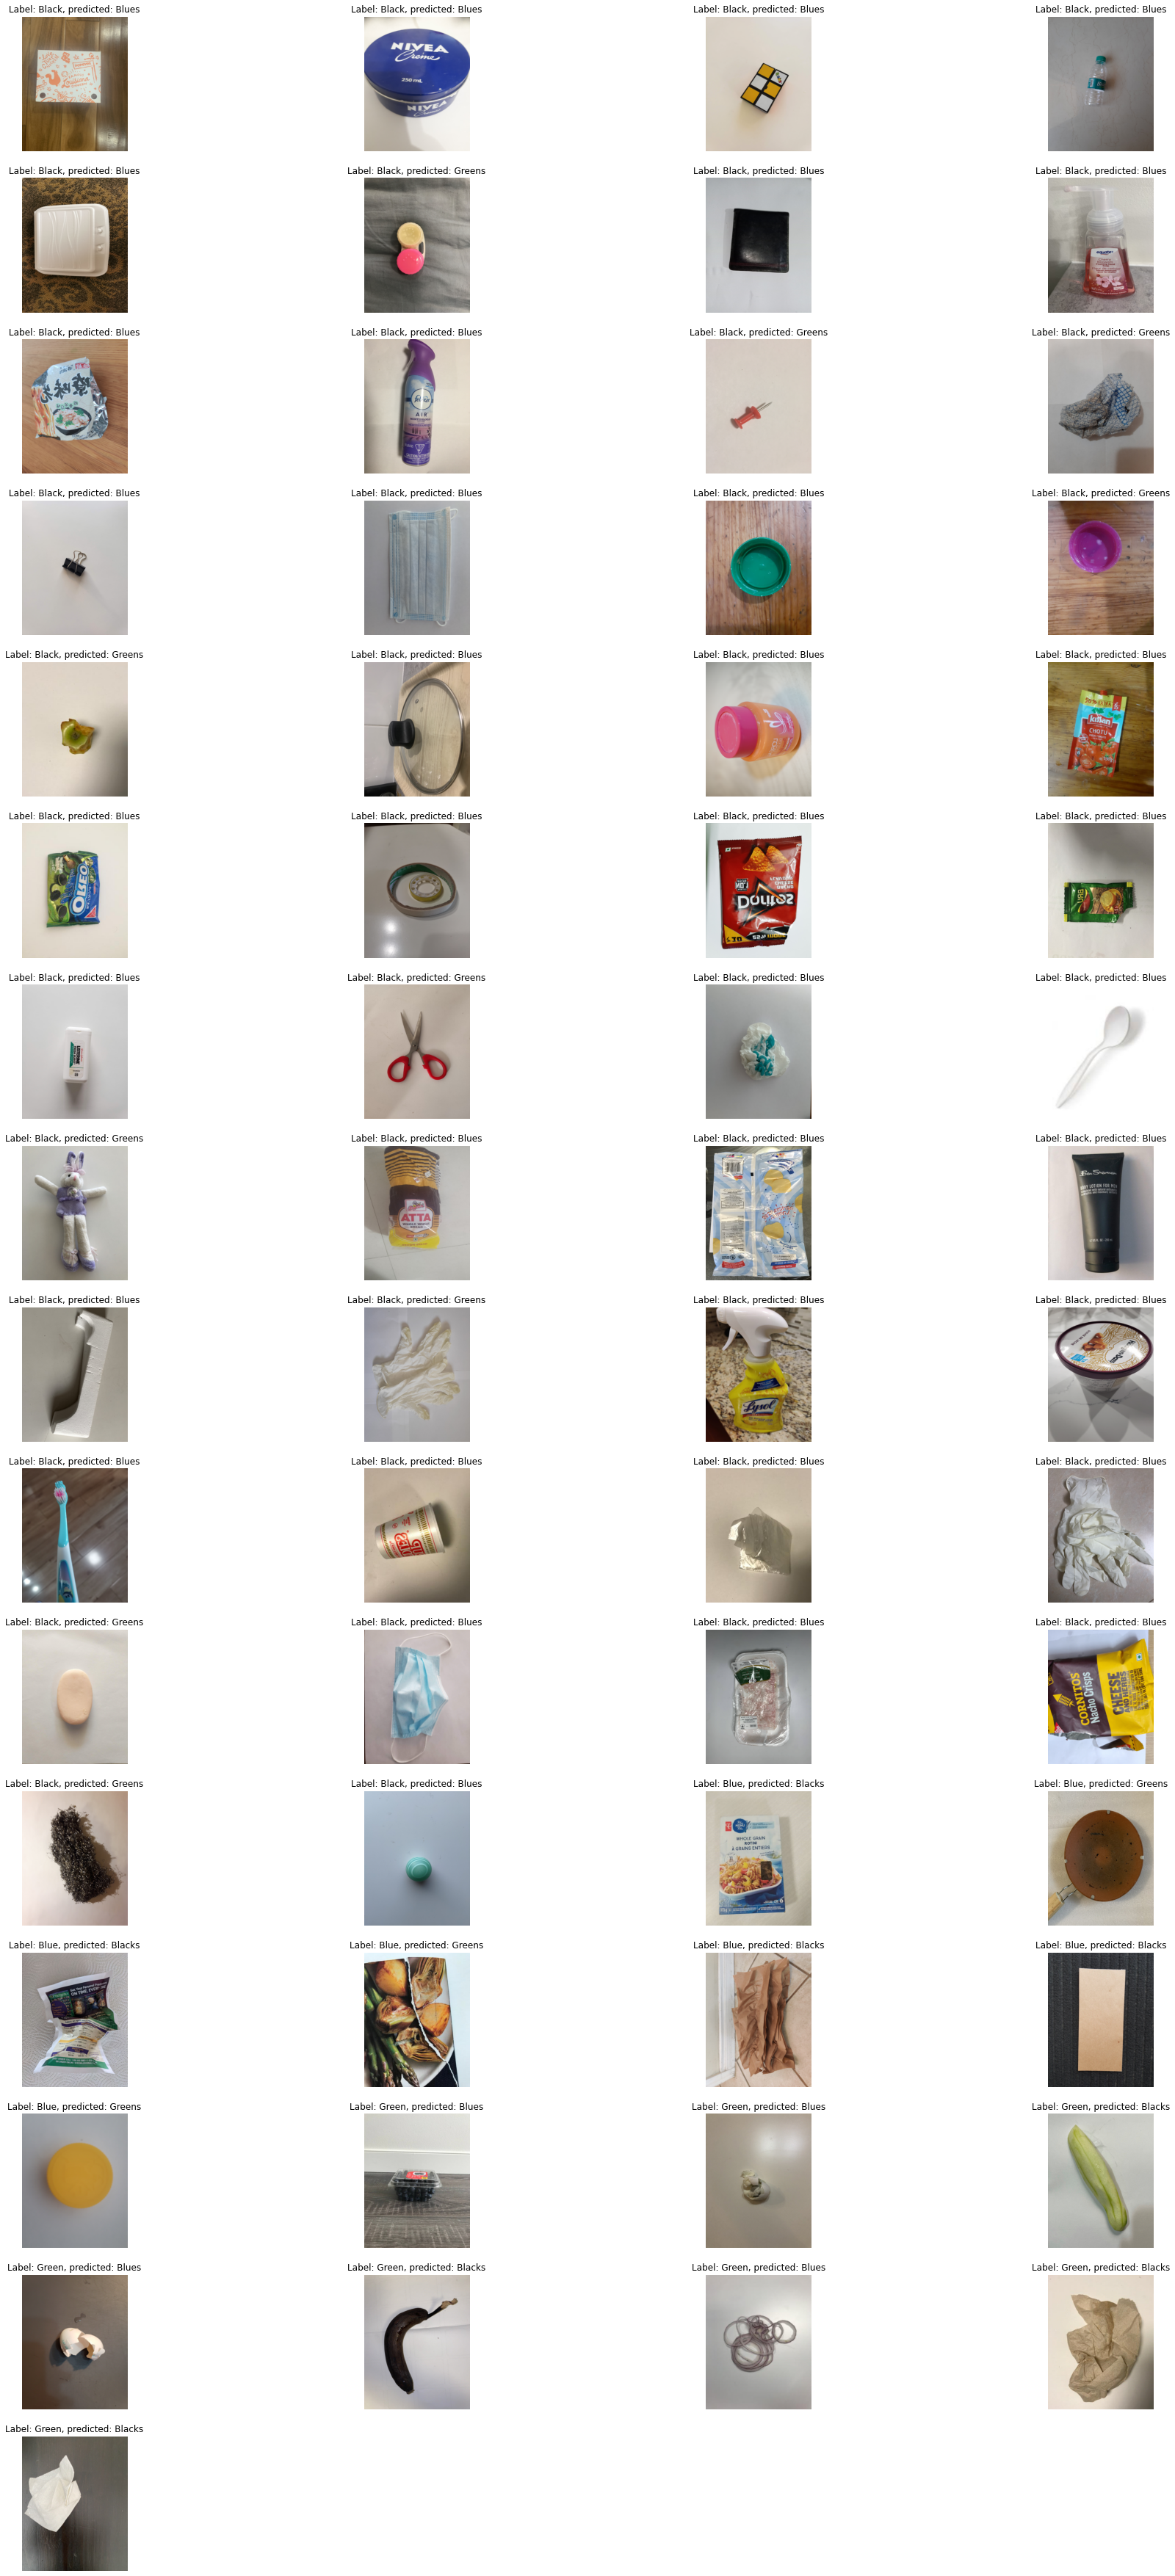

In [53]:
img = []
true_label = []
pred_label = []
for ii in range(nb_samples//batch_size):
    Xbatch,Ybatch = test_generator.__getitem__(ii)
    Ybatch = Ybatch.argmax(axis = 1)
    Ypred = model.predict(Xbatch).argmax(axis = 1)
    wrong_indexes = np.where(Ypred != Ybatch)[0]
    for ii in wrong_indexes:
        img.append(Xbatch[ii])
        true_label.append(Ybatch[ii])
        pred_label.append(Ypred[ii])

columns = 4
rows = len(img)//columns + 1    
plt.figure(figsize = (32,64))
for ii in range(len(img)):
    plt.subplot(rows,columns,ii+1)
    plt.imshow(img[ii], cmap = "gray")
    plt.axis("off")
    plt.title("Label: %s, predicted: %ss" %(class_names[true_label[ii]]\
                                            ,class_names[pred_label[ii]]))
plt.show()